### Import block

In [6]:
import os
import pandas as pd
import datetime as dt
import numpy as np
import altair as alt
import geopy.distance as gpx
import geopandas as gpd
from scipy.sparse import coo_matrix
import itertools

### Function definitions

In [7]:
def one_hot_stack(px_combined,
                 centroid_lat = 0,
                 centroid_lon = 0,
                 centroid_date = dt.datetime.strptime('2017/01/01','%Y/%m/%d'),
                 span = 100,
                 days_back = 10,
                 days_forward = 5):
    
    min_date = centroid_date - dt.timedelta(days = days_back)
    max_date = centroid_date + dt.timedelta(days = days_forward)

    # Calculate location if we move 375 meters North and use to get grid steps.
    lat_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=0).latitude
    lat_step = abs(centroid_lat - lat_375)

    # Calculate location if we move 375 meters East and use to get grid steps.
    lon_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=90).longitude
    lon_step = abs(centroid_lon - lon_375)

    # Get bounding box of centroid and 100 pixels in all directions.
    min_lat = centroid_lat - (lat_step * span + 1)
    max_lat = centroid_lat + (lat_step * span)
    min_lon = centroid_lon - (lon_step * span + 1)
    max_lon = centroid_lon + (lon_step * span)

    # Filter data down to the range we want to plot
    t_df = px_combined[(px_combined['Date'] >= min_date) & (px_combined['Date'] <= max_date)]
    t_df = t_df[(t_df['Lat'] >= min_lat) & (t_df['Lat'] <= max_lat) & (t_df['Lon'] >= min_lon) & (t_df['Lon'] <= max_lon)]

    # Calculate pixel locations in the new grid.
    t_df['delta_lat'] = t_df['Lat'] - centroid_lat
    t_df['delta_lon'] = t_df['Lon'] - centroid_lon
    t_df['lat_grid'] = t_df['delta_lat'] // lat_step
    t_df['lon_grid'] = t_df['delta_lon'] // lon_step

    # Express date difference
    t_df['delta_day'] = (t_df['Date'] - centroid_date).dt.days
    
    # Convert grids to not have negative locations.
    t_df['lat_grid'] = t_df['lat_grid'] + span
    t_df['lon_grid'] = t_df['lon_grid'] + span
    
    # Build an array for each day in our date range then stack them. One for the inputs and one for the outputs.
    input_stack = []
    for x in range(-days_back, 1):
        s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
        if len(s_df) > 0:
            cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
            cm = np.pad(cm, pad_width=((0, (2 * span) - cm.shape[0]),(0,(2 * span) - cm.shape[1])), mode = 'constant')
        else:
            cm = np.zeros(((2 * span),(2 * span)))
        input_stack.append(cm)
    input_stack = np.stack(input_stack)

    output_stack = []
    for x in range(1, days_forward + 1): 
        s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
        if len(s_df) > 0:
            cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
            cm = np.pad(cm, pad_width=((0, (2 * span) - cm.shape[0]),(0,(2 * span) - cm.shape[1])), mode = 'constant')
        else:
            cm = np.zeros(((2 * span),(2 * span)))
        output_stack.append(cm)
    output_stack = np.stack(output_stack)
    
    return input_stack, output_stack

In [8]:
def feature_stack(px_combined,
                 centroid_lat = 0,
                 centroid_lon = 0,
                 centroid_date = dt.datetime.strptime('2017/01/01','%Y/%m/%d'),
                 span = 100,
                 days_back = 10,
                 days_forward = 5):
    
    min_date = centroid_date - dt.timedelta(days = days_back)
    max_date = centroid_date + dt.timedelta(days = days_forward)

    # Calculate location if we move 375 meters North and use to get grid steps.
    lat_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=0).latitude
    lat_step = abs(centroid_lat - lat_375)

    # Calculate location if we move 375 meters East and use to get grid steps.
    lon_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=90).longitude
    lon_step = abs(centroid_lon - lon_375)

    # Get bounding box of centroid and 100 pixels in all directions.
    min_lat = centroid_lat - (lat_step * span + 1)
    max_lat = centroid_lat + (lat_step * span)
    min_lon = centroid_lon - (lon_step * span + 1)
    max_lon = centroid_lon + (lon_step * span)

    # Filter data down to the range we want to plot
    t_df = px_combined[(px_combined['Date'] >= min_date) & (px_combined['Date'] <= max_date)]
    t_df = t_df[(t_df['Lat'] >= min_lat) & (t_df['Lat'] <= max_lat) & (t_df['Lon'] >= min_lon) & (t_df['Lon'] <= max_lon)]

    # Calculate pixel locations in the new grid.
    t_df['delta_lat'] = t_df['Lat'] - centroid_lat
    t_df['delta_lon'] = t_df['Lon'] - centroid_lon
    t_df['lat_grid'] = t_df['delta_lat'] // lat_step
    t_df['lon_grid'] = t_df['delta_lon'] // lon_step

    # Express date difference
    t_df['delta_day'] = (t_df['Date'] - centroid_date).dt.days
    
    # Convert grids to not have negative locations.
    t_df['lat_grid'] = t_df['lat_grid'] + span
    t_df['lon_grid'] = t_df['lon_grid'] + span
    
    # Build an array for each day in our date range then stack them. One for the inputs and one for the outputs.
    input_stack = []
    for x in range(-days_back, 1):
        s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
        if len(s_df) > 0:
            cm1 = coo_matrix((s_df['T4'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
            cm1 = np.pad(cm1, pad_width=((0, 201 - cm1.shape[0]),(0,(2 * span) - cm1.shape[1])), mode = 'constant')
            cm2 = coo_matrix((s_df['T5'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
            cm2 = np.pad(cm2, pad_width=((0, 201 - cm2.shape[0]),(0,(2 * span) - cm2.shape[1])), mode = 'constant')
            cm3 = coo_matrix((s_df['FRP'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
            cm3 = np.pad(cm3, pad_width=((0, 201 - cm3.shape[0]),(0,(2 * span) - cm3.shape[1])), mode = 'constant')
            cm4 = coo_matrix((s_df['Rad13'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
            cm4 = np.pad(cm4, pad_width=((0, 201 - cm4.shape[0]),(0,(2 * span) - cm4.shape[1])), mode = 'constant')
        else:
            cm1 = np.zeros(((2 * span),(2 * span)))
            cm2 = np.zeros(((2 * span),(2 * span)))
            cm3 = np.zeros(((2 * span),(2 * span)))
            cm4 = np.zeros(((2 * span),(2 * span)))
        input_stack.append(np.stack([cm1, cm2, cm3, cm4]))
    input_stack = np.stack(input_stack)

    output_stack = []
    for x in range(1, days_forward + 1):
        s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
        if len(s_df) > 0:
            cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
            cm = np.pad(cm, pad_width=((0, (2 * span) - cm.shape[0]),(0,(2 * span) - cm.shape[1])), mode = 'constant')
        else:
            cm = np.zeros(((2 * span),(2 * span)))
        output_stack.append(cm)
    output_stack = np.stack(output_stack)
    
    return input_stack, output_stack

In [9]:
def one_hot_with_defo_stack(px_combined,
                            defo_gpd,
                            centroid_lat = 0,
                            centroid_lon = 0,
                            centroid_date = dt.datetime.strptime('2017/01/01','%Y/%m/%d'),
                            span = 15,
                            days_back = 9,
                            days_forward = 10):
    
    min_date = centroid_date - dt.timedelta(days = days_back)
    max_date = centroid_date + dt.timedelta(days = days_forward)

    # Calculate location if we move 375 meters North and use to get grid steps.
    lat_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=0).latitude
    lat_step = abs(centroid_lat - lat_375)

    # Calculate location if we move 375 meters East and use to get grid steps.
    lon_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=90).longitude
    lon_step = abs(centroid_lon - lon_375)

    # Get bounding box of centroid and span pixels in all directions.
    min_lat = centroid_lat - (lat_step * (span + 1))
    max_lat = centroid_lat + (lat_step * span)
    min_lon = centroid_lon - (lon_step * (span + 1))
    max_lon = centroid_lon + (lon_step * span)

    # Filter data down to the range we want to plot
    t_df = px_combined[(px_combined['Date'] >= min_date) & (px_combined['Date'] <= max_date)]
    t_df = t_df[(t_df['Lat'] >= min_lat) & (t_df['Lat'] <= max_lat) & (t_df['Lon'] >= min_lon) & (t_df['Lon'] <= max_lon)]

    # Calculate pixel locations in the new grid.
    t_df['delta_lat'] = t_df['Lat'] - centroid_lat
    t_df['delta_lon'] = t_df['Lon'] - centroid_lon
    t_df['lat_grid'] = t_df['delta_lat'] // lat_step
    t_df['lon_grid'] = t_df['delta_lon'] // lon_step

    # Express date difference
    t_df['delta_day'] = (t_df['Date'] - centroid_date).dt.days

    # Convert grids to not have negative locations.
    t_df['lat_grid'] = t_df['lat_grid'] + span + 1
    t_df['lon_grid'] = t_df['lon_grid'] + span + 1

    ### Begin added code for deforestation processing.

    # Limit deforestation polygons to those that intersect with centroid grid.
    centroid_defo = defo_gpd[(defo_gpd['x_min'] >= min_lon) & (defo_gpd['x_max'] <= max_lon) &
                   (defo_gpd['y_min'] >= min_lat) & (defo_gpd['y_max'] <= max_lat) &
                   (defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] != 0) &
                   (defo_gpd['Date'] <= min_date)]

    if len(centroid_defo) > 0:
        # Build grid.
        lats = [min_lat + lat_step * x for x in range(0,span * 2 + 2)]
        lons = [min_lon + lon_step * x for x in range(0,span * 2 + 2)]
        cs = [c for c in range(0,span * 2 + 2)]
        grid = list(itertools.product(lons, lats))
        grid_xy = list(itertools.product(cs, cs))
        grid_points = gpd.points_from_xy([x[0] for x in grid], [y[1] for y in grid])
        grid_gdf = gpd.GeoDataFrame(grid_points)
        grid_gdf.rename(mapper={0:'geometry'}, axis=1, inplace = True)
        grid_gdf['x'] = [c[0] for c in grid_xy]
        grid_gdf['y'] = [c[1] for c in grid_xy]
        grid_gdf = grid_gdf.set_geometry('geometry')
        grid_gdf.crs = 'epsg:4674'

        # Calculate deforested gridpoints.
        grid_gdf['deforested'] = np.minimum(pd.concat(
            [grid_gdf.within(centroid_defo.iloc[x].geometry.buffer(0)) for x in range(0,len(centroid_defo))]
            , axis=1).sum(1),1)

        # Convert to numpy format.
        dm = coo_matrix((grid_gdf['deforested'],(grid_gdf['x'].astype(int),grid_gdf['y'].astype(int)))).toarray()
    else:
        dm = np.zeros(((2 * span + 2),(2 * span + 2)))

    ### End added code for deforestaion processing.

    # Build an array for each day in our date range then stack them. One for the inputs and one for the outputs.
    input_stack = []
    for x in range(-days_back, 1):
        s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
        if len(s_df) > 0:
            cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
            cm = np.pad(cm, pad_width=((0, (2 * span + 2) - cm.shape[0]),(0,(2 * span + 2) - cm.shape[1])), mode = 'constant')
        else:
            cm = np.zeros(((2 * span + 2),(2 * span + 2)))
        input_stack.append(np.stack([cm, dm])) # All deforestation frames (dm) remain constant.
    input_stack = np.stack(input_stack)

    output_stack = []
    for x in range(1, days_forward + 1):
        s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
        if len(s_df) > 0:
            cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
            cm = np.pad(cm, pad_width=((0, (2 * span + 2) - cm.shape[0]),(0,(2 * span + 2) - cm.shape[1])), mode = 'constant')
        else:
            cm = np.zeros(((2 * span + 2),(2 * span + 2)))
        output_stack.append(np.stack(cm)) # All deforestation frames (dm) remain constant.
    output_stack = np.stack(output_stack)
        
        
    return input_stack, output_stack

In [10]:
def one_hot_stack_and_save(
                 centroid_df,
                 px_combined,
                 meta_folder = '/data/',
                 feature_folder = '/data/features/',
                 label_folder = '/data/labels/',
                 span = 100,
                 days_back = 10,
                 days_forward = 5):
    
    meta_df = centroid_df.copy()
    meta_df['features'] = feature_folder + meta_df.index.astype(str) + '.npy'
    meta_df['labels'] = label_folder + meta_df.index.astype(str) + '.npy'
    
    for x in range(0,len(centroid_df)):
        
        t_index = centroid_df.index[x].astype(str)
        centroid_lat = centroid_df.iloc[x].Lat
        centroid_lon = centroid_df.iloc[x].Lon
        centroid_date = centroid_df.iloc[x].Date
        
        min_date = centroid_date - dt.timedelta(days = days_back)
        max_date = centroid_date + dt.timedelta(days = days_forward)

        # Calculate location if we move 375 meters North and use to get grid steps.
        lat_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=0).latitude
        lat_step = abs(centroid_lat - lat_375)

        # Calculate location if we move 375 meters East and use to get grid steps.
        lon_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=90).longitude
        lon_step = abs(centroid_lon - lon_375)

        # Get bounding box of centroid and 100 pixels in all directions.
        min_lat = centroid_lat - (lat_step * span + 1)
        max_lat = centroid_lat + (lat_step * span)
        min_lon = centroid_lon - (lon_step * span + 1)
        max_lon = centroid_lon + (lon_step * span)

        # Filter data down to the range we want to plot
        t_df = px_combined[(px_combined['Date'] >= min_date) & (px_combined['Date'] <= max_date)]
        t_df = t_df[(t_df['Lat'] >= min_lat) & (t_df['Lat'] <= max_lat) & (t_df['Lon'] >= min_lon) & (t_df['Lon'] <= max_lon)]

        # Calculate pixel locations in the new grid.
        t_df['delta_lat'] = t_df['Lat'] - centroid_lat
        t_df['delta_lon'] = t_df['Lon'] - centroid_lon
        t_df['lat_grid'] = t_df['delta_lat'] // lat_step
        t_df['lon_grid'] = t_df['delta_lon'] // lon_step

        # Express date difference
        t_df['delta_day'] = (t_df['Date'] - centroid_date).dt.days

        # Convert grids to not have negative locations.
        t_df['lat_grid'] = t_df['lat_grid'] + span
        t_df['lon_grid'] = t_df['lon_grid'] + span

        # Build an array for each day in our date range then stack them. One for the inputs and one for the outputs.
        input_stack = []
        for x in range(-days_back, 1):
            s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
            if len(s_df) > 0:
                cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
                cm = np.pad(cm, pad_width=((0, (2 * span) - cm.shape[0]),(0,(2 * span) - cm.shape[1])), mode = 'constant')
            else:
                cm = np.zeros(((2 * span),(2 * span)))
            input_stack.append(cm)
        input_stack = np.stack(input_stack)

        output_stack = []
        for x in range(1, days_forward + 1):
            s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
            if len(s_df) > 0:
                cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
                cm = np.pad(cm, pad_width=((0, (2 * span) - cm.shape[0]),(0,(2 * span) - cm.shape[1])), mode = 'constant')
            else:
                cm = np.zeros(((2 * span),(2 * span)))
            output_stack.append(cm)
        output_stack = np.stack(output_stack)
        
        # Save to disk
        np.save(feature_folder + t_index + '.npy', input_stack)
        np.save(label_folder + t_index + '.npy', output_stack)
        
    meta_df.to_csv(meta_folder + 'meta.csv')

In [11]:
def feature_stack_and_save(
                 centroid_df,
                 px_combined,
                 meta_folder = '/data/',
                 feature_folder = '/data/features/',
                 label_folder = '/data/labels/',
                 span = 100,
                 days_back = 10,
                 days_forward = 5):
    
    meta_df = centroid_df.copy()
    meta_df['features'] = feature_folder + meta_df.index.astype(str) + '.npy'
    meta_df['labels'] = label_folder + meta_df.index.astype(str) + '.npy'
    
    for x in range(0,len(centroid_df)):
        
        t_index = centroid_df.index[x].astype(str)
        centroid_lat = centroid_df.iloc[x].Lat
        centroid_lon = centroid_df.iloc[x].Lon
        centroid_date = centroid_df.iloc[x].Date
        
        min_date = centroid_date - dt.timedelta(days = days_back)
        max_date = centroid_date + dt.timedelta(days = days_forward)

        # Calculate location if we move 375 meters North and use to get grid steps.
        lat_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=0).latitude
        lat_step = abs(centroid_lat - lat_375)

        # Calculate location if we move 375 meters East and use to get grid steps.
        lon_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=90).longitude
        lon_step = abs(centroid_lon - lon_375)

        # Get bounding box of centroid and 100 pixels in all directions.
        min_lat = centroid_lat - (lat_step * span + 1)
        max_lat = centroid_lat + (lat_step * span)
        min_lon = centroid_lon - (lon_step * span + 1)
        max_lon = centroid_lon + (lon_step * span)

        # Filter data down to the range we want to plot
        t_df = px_combined[(px_combined['Date'] >= min_date) & (px_combined['Date'] <= max_date)]
        t_df = t_df[(t_df['Lat'] >= min_lat) & (t_df['Lat'] <= max_lat) & (t_df['Lon'] >= min_lon) & (t_df['Lon'] <= max_lon)]

        # Calculate pixel locations in the new grid.
        t_df['delta_lat'] = t_df['Lat'] - centroid_lat
        t_df['delta_lon'] = t_df['Lon'] - centroid_lon
        t_df['lat_grid'] = t_df['delta_lat'] // lat_step
        t_df['lon_grid'] = t_df['delta_lon'] // lon_step

        # Express date difference
        t_df['delta_day'] = (t_df['Date'] - centroid_date).dt.days

        # Convert grids to not have negative locations.
        t_df['lat_grid'] = t_df['lat_grid'] + span
        t_df['lon_grid'] = t_df['lon_grid'] + span

        # Build an array for each day in our date range then stack them. One for the inputs and one for the outputs.
        input_stack = []
        for x in range(-days_back, 1):
            s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
            if len(s_df) > 0:
                cm1 = coo_matrix((s_df['T4'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
                cm1 = np.pad(cm1, pad_width=((0, (2 * span) - cm1.shape[0]),(0,(2 * span) - cm1.shape[1])), mode = 'constant')
                cm2 = coo_matrix((s_df['T5'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
                cm2 = np.pad(cm2, pad_width=((0, (2 * span) - cm2.shape[0]),(0,(2 * span) - cm2.shape[1])), mode = 'constant')
                cm3 = coo_matrix((s_df['FRP'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
                cm3 = np.pad(cm3, pad_width=((0, (2 * span) - cm3.shape[0]),(0,(2 * span) - cm3.shape[1])), mode = 'constant')
                cm4 = coo_matrix((s_df['Rad13'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
                cm4 = np.pad(cm4, pad_width=((0, (2 * span) - cm4.shape[0]),(0,(2 * span) - cm4.shape[1])), mode = 'constant')
            else:
                cm1 = np.zeros(((2 * span),(2 * span)))
                cm2 = np.zeros(((2 * span),(2 * span)))
                cm3 = np.zeros(((2 * span),(2 * span)))
                cm4 = np.zeros(((2 * span),(2 * span)))
            input_stack.append(np.stack([cm1, cm2, cm3, cm4]))
        input_stack = np.stack(input_stack)

        output_stack = []
        for x in range(1, days_forward + 1):
            s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
            if len(s_df) > 0:
                cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
                cm = np.pad(cm, pad_width=((0, (2 * span) - cm.shape[0]),(0,(2 * span) - cm.shape[1])), mode = 'constant')
            else:
                cm = np.zeros(((2 * span),(2 * span)))
            output_stack.append(cm)
        output_stack = np.stack(output_stack)
        
        
        
        # Save to disk
        np.save(feature_folder + t_index + '.npy', input_stack)
        np.save(label_folder + t_index + '.npy', output_stack)
        
    meta_df.to_csv(meta_folder + 'meta.csv')

In [12]:
def one_hot_with_defo_stack_and_save(
                 centroid_df,
                 defo_gpd,
                 px_combined,
                 meta_folder = '/data/',
                 feature_folder = '/data/features/',
                 label_folder = '/data/labels/',
                 span = 15,
                 days_back = 10,
                 days_forward = 10):
    
    meta_df = centroid_df.copy()
    meta_df['features'] = feature_folder + meta_df.index.astype(str) + '.npy'
    meta_df['labels'] = label_folder + meta_df.index.astype(str) + '.npy'
    
    for x in range(0,len(centroid_df)):
        
        t_index = centroid_df.index[x].astype(str)
        centroid_lat = centroid_df.iloc[x].Lat
        centroid_lon = centroid_df.iloc[x].Lon
        centroid_date = centroid_df.iloc[x].Date
        
        min_date = centroid_date - dt.timedelta(days = days_back)
        max_date = centroid_date + dt.timedelta(days = days_forward)

        # Calculate location if we move 375 meters North and use to get grid steps.
        lat_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=0).latitude
        lat_step = abs(centroid_lat - lat_375)

        # Calculate location if we move 375 meters East and use to get grid steps.
        lon_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=90).longitude
        lon_step = abs(centroid_lon - lon_375)

        # Get bounding box of centroid and span pixels in all directions.
        min_lat = centroid_lat - (lat_step * (span + 1))
        max_lat = centroid_lat + (lat_step * span)
        min_lon = centroid_lon - (lon_step * (span + 1))
        max_lon = centroid_lon + (lon_step * span)
        
        # Filter data down to the range we want to plot
        t_df = px_combined[(px_combined['Date'] >= min_date) & (px_combined['Date'] <= max_date)]
        t_df = t_df[(t_df['Lat'] >= min_lat) & (t_df['Lat'] <= max_lat) & (t_df['Lon'] >= min_lon) & (t_df['Lon'] <= max_lon)]

        # Calculate pixel locations in the new grid.
        t_df['delta_lat'] = t_df['Lat'] - centroid_lat
        t_df['delta_lon'] = t_df['Lon'] - centroid_lon
        t_df['lat_grid'] = t_df['delta_lat'] // lat_step
        t_df['lon_grid'] = t_df['delta_lon'] // lon_step

        # Express date difference
        t_df['delta_day'] = (t_df['Date'] - centroid_date).dt.days

        # Convert grids to not have negative locations.
        t_df['lat_grid'] = t_df['lat_grid'] + span + 1
        t_df['lon_grid'] = t_df['lon_grid'] + span + 1
        
        ### Begin added code for deforestation processing.
        
        # Limit deforestation polygons to those that intersect with centroid grid.
        centroid_defo = defo_gpd[(defo_gpd['x_min'] >= min_lon) & (defo_gpd['x_max'] <= max_lon) &
                       (defo_gpd['y_min'] >= min_lat) & (defo_gpd['y_max'] <= max_lat) &
                       (defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] != 0) &
                       (defo_gpd['Date'] <= min_date)]
        
        if len(centroid_defo) > 0:
            # Build grid.
            lats = [min_lat + lat_step * x for x in range(0,span * 2 + 2)]
            lons = [min_lon + lon_step * x for x in range(0,span * 2 + 2)]
            cs = [c for c in range(0,span * 2 + 2)]
            grid = list(itertools.product(lons, lats))
            grid_xy = list(itertools.product(cs, cs))
            grid_points = gpd.points_from_xy([x[0] for x in grid], [y[1] for y in grid])
            grid_gdf = gpd.GeoDataFrame(grid_points)
            grid_gdf.rename(mapper={0:'geometry'}, axis=1, inplace = True)
            grid_gdf['x'] = [c[0] for c in grid_xy]
            grid_gdf['y'] = [c[1] for c in grid_xy]
            grid_gdf = grid_gdf.set_geometry('geometry')
            grid_gdf.crs = 'epsg:4674'

            # Calculate deforested gridpoints.
            grid_gdf['deforested'] = np.minimum(pd.concat(
                [grid_gdf.within(centroid_defo.iloc[x].geometry.buffer(0)) for x in range(0,len(centroid_defo))]
                , axis=1).sum(1),1)

            # Convert to numpy format.
            dm = coo_matrix((grid_gdf['deforested'],(grid_gdf['x'].astype(int),grid_gdf['y'].astype(int)))).toarray()
        else:
            dm = np.zeros(((2 * span + 2),(2 * span + 2)))
        
        ### End added code for deforestaion processing.

        # Build an array for each day in our date range then stack them. One for the inputs and one for the outputs.
        input_stack = []
        for x in range(-days_back, 1):
            s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
            if len(s_df) > 0:
                cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
                cm = np.pad(cm, pad_width=((0, (2 * span + 2) - cm.shape[0]),(0,(2 * span + 2) - cm.shape[1])), mode = 'constant')
            else:
                cm = np.zeros(((2 * span + 2),(2 * span + 2)))
            input_stack.append([cm, dm]) # All deforestation frames (dm) remain constant.
        input_stack = np.stack(input_stack)

        output_stack = []
        for x in range(1, days_forward + 1):
            s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
            if len(s_df) > 0:
                cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
                cm = np.pad(cm, pad_width=((0, (2 * span + 2) - cm.shape[0]),(0,(2 * span + 2) - cm.shape[1])), mode = 'constant')
            else:
                cm = np.zeros(((2 * span + 2),(2 * span + 2)))
            output_stack.append(np.stack(cm))
        output_stack = np.stack(output_stack)
        
        ## Save to disk
        np.save(feature_folder + t_index + '.npy', input_stack)
        np.save(label_folder + t_index + '.npy', output_stack)
        
    meta_df.to_csv(meta_folder + 'meta.csv')

### Data import

In [13]:
# Get deforestation data from shapefile.
defo_gpd = gpd.read_file('Yearly_Deforestation_Biome/yearly_deforestation_biome.shp')

# Filter to deforestation shapes in Para.
defo_gpd = defo_gpd[defo_gpd['state'] == 'PA']

# Add bounding boxes to DataFrame.
gpd_bbox = defo_gpd.bounds
defo_gpd['x_min'] = gpd_bbox['minx']
defo_gpd['x_max'] = gpd_bbox['maxx']
defo_gpd['y_min'] = gpd_bbox['miny']
defo_gpd['y_max'] = gpd_bbox['maxy']

# Convert date format.
defo_gpd['Date'] = pd.to_datetime(defo_gpd['image_date'])

In [14]:
# Load VIIRS fire data.
px_combined = pd.read_csv('VIIRS_Para.csv')

In [15]:
# Adjust date format.
px_combined['Date'] = pd.to_datetime(px_combined['YYYYMMDD'].astype(str))

In [16]:
# Add month column so we can sample from September only.
px_combined['Month'] = px_combined['Date'].dt.month

# Add year column so we can segregate train/val/test by year.
px_combined['Year'] = px_combined['Date'].dt.year

In [17]:
# Add a column where every value is a 1 to use in 1-hot encoding strategy.
px_combined['value'] = 1

In [18]:
## Limit to night pixels only.
#px_combined = px_combined[px_combined['DNFlag'] == 'night']

In [19]:
px_combined[px_combined['Date'] == '09/15/2017'].iloc[15]

Unnamed: 0                             1087986
Unnamed: 0.1                            358467
Unnamed: 0.1.1                         1463797
YYYYMMDD                              20170915
HHMM                                       430
sat                                        VNP
Line                                      1932
Sample                                    1530
Lat                                  -1.672125
Lon                                 -53.617889
T4                                      307.47
T5                                      273.02
MeanT4                                  288.38
MeanT5                                  279.27
MeanDT                                    9.11
MADT4                                     1.88
MADT5                                     3.31
MADDT                                    -1.44
FRP                                       1.27
Rad13                                    0.423
Mean13                                    0.36
AdjC         

#### Testing code concepts on one example

In [20]:
centroid_lat = -1.672125
centroid_lon = -53.617889
centroid_date = dt.datetime.strptime('2017/09/13','%Y/%m/%d')
days_back = 9
days_forward = 10
min_date = centroid_date - dt.timedelta(days = days_back)
max_date = centroid_date + dt.timedelta(days = days_forward)

# Calculate location if we move 375 meters North and use to get grid steps.
lat_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=0).latitude
lat_step = abs(centroid_lat - lat_375)

# Calculate location if we move 375 meters East and use to get grid steps.
lon_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=90).longitude
lon_step = abs(centroid_lon - lon_375)

# Get bounding box of centroid and 100 pixels in all directions.
min_lat = centroid_lat - (lat_step * 16)
max_lat = centroid_lat + (lat_step * 15)
min_lon = centroid_lon - (lon_step * 16)
max_lon = centroid_lon + (lon_step * 15)

# Filter data down to the range we want to plot
t_df = px_combined[(px_combined['Date'] >= min_date) & (px_combined['Date'] <= max_date)]
t_df = t_df[(t_df['Lat'] >= min_lat) & (t_df['Lat'] <= max_lat) & (t_df['Lon'] >= min_lon) & (t_df['Lon'] <= max_lon)]

# Calculate pixel locations in the new grid.
t_df['delta_lat'] = t_df['Lat'] - centroid_lat
t_df['delta_lon'] = t_df['Lon'] - centroid_lon
t_df['lat_grid'] = t_df['delta_lat'] // lat_step
t_df['lon_grid'] = t_df['delta_lon'] // lon_step

# Express date difference
t_df['delta_day'] = (t_df['Date'] - centroid_date).dt.days

In [21]:
# Add tooltip for plot
t_df['tool'] = t_df['lon_grid'].astype(str) + ' x ' + t_df['lat_grid'].astype(str)

# Show new grid in a plot.
alt.Chart(t_df[['lat_grid', 'lon_grid', 'Date', 'tool']]).mark_circle(size=250).encode(
    alt.X('lon_grid', title = 'Lon', axis=alt.Axis(labels=False)),
    alt.Y('lat_grid', title = 'Lat', axis=alt.Axis(labels=False)),
    color = alt.Color('Date:N', scale=alt.Scale(scheme = 'category20')),
    tooltip = 'tool'
).properties(height=600, width=600).interactive()

alt.Chart(...)

In [22]:
# Illustrate what we are asking model to predict.
span = 16

source = alt.Chart(t_df[t_df['Date'] <= centroid_date][['lat_grid', 'lon_grid', 'Date', 'tool']]
                  ,title = 'Source Data').mark_circle(size=250).encode(
    alt.X('lon_grid', title = 'Lon', axis=alt.Axis(labels=False), scale=alt.Scale(domain=[-span + 1, span])),
    alt.Y('lat_grid', title = 'Lat', axis=alt.Axis(labels=False), scale=alt.Scale(domain=[-span + 1, span])),
    color = alt.Color('Date:N', scale=alt.Scale(scheme = 'category20')),
    tooltip = 'tool'
).properties(height=300, width=300).interactive()

target = alt.Chart(t_df[t_df['Date'] > centroid_date][['lat_grid', 'lon_grid', 'Date', 'tool']]
                  ,title = 'Target Prediction').mark_circle(size=250).encode(
    alt.X('lon_grid', title = 'Lon', axis=alt.Axis(labels=False), scale=alt.Scale(domain=[-span + 1, span])),
    alt.Y('lat_grid', title = 'Lat', axis=alt.Axis(labels=False), scale=alt.Scale(domain=[-span + 1, span])),
    color = alt.Color('Date:N', scale=alt.Scale(scheme = 'category20')),
    tooltip = 'tool'
).properties(height=300, width=300).interactive()

source | target

alt.HConcatChart(...)

### One-hot encoding strategy

In [23]:
# Convert grids to not have negative locations.
t_df['lat_grid'] = t_df['lat_grid'] + span
t_df['lon_grid'] = t_df['lon_grid'] + span

In [24]:
# Examine array for centroid date.
s_df = t_df[t_df['Date'] == centroid_date]
cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
cm = np.pad(cm, pad_width=((0, span * 2),(0,201 - span * 2)), mode = 'constant')

# Confirm that the right number of pixels are mapped.
pd.DataFrame(cm).sum().sum()

39

In [25]:
s_df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,YYYYMMDD,HHMM,sat,Line,Sample,Lat,Lon,...,Date,Month,Year,value,delta_lat,delta_lon,lat_grid,lon_grid,delta_day,tool
150673,1030407,300888,1234657,20170913,506,VNP,3700,3909,-1.665765,-53.628784,...,2017-09-13,9,2017,1,0.006360,-0.010895,17.0,12.0,0,-4.0 x 1.0
150674,1030408,300889,1234658,20170913,506,VNP,3701,3909,-1.669297,-53.629337,...,2017-09-13,9,2017,1,0.002828,-0.011448,16.0,12.0,0,-4.0 x 0.0
150677,1030411,300892,1234661,20170913,506,VNP,3701,3908,-1.668678,-53.633286,...,2017-09-13,9,2017,1,0.003447,-0.015397,17.0,11.0,0,-5.0 x 1.0
150678,1030412,300893,1234662,20170913,506,VNP,3702,3908,-1.672209,-53.633835,...,2017-09-13,9,2017,1,-0.000084,-0.015946,15.0,11.0,0,-5.0 x -1.0
150682,1030416,300897,1234666,20170913,506,VNP,3703,3916,-1.680716,-53.602753,...,2017-09-13,9,2017,1,-0.008591,0.015136,13.0,20.0,0,4.0 x -3.0
150685,1030419,300900,1234669,20170913,506,VNP,3705,3915,-1.687169,-53.607796,...,2017-09-13,9,2017,1,-0.015044,0.010093,11.0,18.0,0,2.0 x -5.0
150686,1030420,300901,1234670,20170913,506,VNP,3705,3916,-1.687790,-53.603855,...,2017-09-13,9,2017,1,-0.015665,0.014034,11.0,20.0,0,4.0 x -5.0
156529,1046900,317381,1318726,20170913,1606,VNP,3159,6270,-1.673050,-53.628563,...,2017-09-13,9,2017,1,-0.000925,-0.010674,15.0,12.0,0,-4.0 x -1.0
156530,1046901,317382,1318727,20170913,1606,VNP,3159,6271,-1.673986,-53.634911,...,2017-09-13,9,2017,1,-0.001861,-0.017022,15.0,10.0,0,-6.0 x -1.0
156531,1046902,317383,1318728,20170913,1606,VNP,3160,6270,-1.666130,-53.629585,...,2017-09-13,9,2017,1,0.005995,-0.011696,17.0,12.0,0,-4.0 x 1.0


In [26]:
# Build an array for each day in our date range then stack them. One for the inputs and one for the outputs.
input_stack = []
for x in range(-days_back, 1):
    s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
    if len(s_df) > 0:
        cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
        cm = np.pad(cm, pad_width=((0, span * 2 - cm.shape[0]),(0,span * 2 - cm.shape[1])), mode = 'constant')
    else:
        cm = np.zeros((span * 2,span * 2))
    input_stack.append(cm)
input_stack = np.stack(input_stack)

output_stack = []
for x in range(1, days_forward + 1):
    s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
    if len(s_df) > 0:
        cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
        cm = np.pad(cm, pad_width=((0, span * 2 - cm.shape[0]),(0,span * 2 - cm.shape[1])), mode = 'constant')
    else:
        cm = np.zeros((span * 2,span * 2))
    output_stack.append(cm)
output_stack = np.stack(output_stack)

In [27]:
input_stack[0].shape

(32, 32)

In [28]:
print('Input Stack Shape:', input_stack.shape)
print('Input Stack Sum:', input_stack.sum())
print('Outpt Stack Shape:', output_stack.shape)
print('Output Stack Sum:', output_stack.sum())
print('Validation Check:', input_stack.sum() + output_stack.sum() == t_df.value.sum())

Input Stack Shape: (10, 32, 32)
Input Stack Sum: 49.0
Outpt Stack Shape: (10, 32, 32)
Output Stack Sum: 37.0
Validation Check: True


In [29]:
# Test function call.
i,o = one_hot_stack(px_combined, 
                    centroid_lat = -17.859758, 
                    centroid_lon = -57.332260, 
                    centroid_date = dt.datetime.strptime('2020/07/06','%Y/%m/%d'))
print('Input Stack Shape:', i.shape)
print('Input Stack Sum:', i.sum())
print('Outpt Stack Shape:', o.shape)
print('Output Stack Sum:', o.sum())

Input Stack Shape: (11, 200, 200)
Input Stack Sum: 0.0
Outpt Stack Shape: (5, 200, 200)
Output Stack Sum: 0.0


### Feature-based encoding strategy

In [30]:
# Create arrays for each feature
s_df = t_df[t_df['Date'] == centroid_date]
cm1 = coo_matrix((s_df['T4'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
cm1 = np.pad(cm1, pad_width=((0, 201 - cm1.shape[0]),(0,201 - cm1.shape[1])), mode = 'constant')
cm2 = coo_matrix((s_df['T5'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
cm2 = np.pad(cm2, pad_width=((0, 201 - cm2.shape[0]),(0,201 - cm2.shape[1])), mode = 'constant')
cm3 = coo_matrix((s_df['FRP'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
cm3 = np.pad(cm3, pad_width=((0, 201 - cm3.shape[0]),(0,201 - cm3.shape[1])), mode = 'constant')
cm4 = coo_matrix((s_df['Rad13'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
cm4 = np.pad(cm4, pad_width=((0, 201 - cm4.shape[0]),(0,201 - cm4.shape[1])), mode = 'constant')

np.stack([cm1,cm2,cm3,cm4]).shape

(4, 201, 201)

In [31]:
# Test function call.
i,o = feature_stack(px_combined, 
                    centroid_lat = -17.859758, 
                    centroid_lon = -57.332260, 
                    centroid_date = dt.datetime.strptime('2020/07/06','%Y/%m/%d'))
print('Input Stack Shape:', i.shape)
print('Input Stack Sum:', i.sum())
print('Outpt Stack Shape:', o.shape)
print('Output Stack Sum:', o.sum())

Input Stack Shape: (11, 4, 200, 200)
Input Stack Sum: 0.0
Outpt Stack Shape: (5, 200, 200)
Output Stack Sum: 0.0


### Create sample datasets

In [32]:
# Build training set.
train_df = px_combined[(px_combined['Month'] == 9) & (px_combined['Year'] < 2020)].sample(frac=0.05,random_state=321)[['Lon','Lat','Date']]
train_df

,Lon,Lat,Date
424178,-53.777985,-6.178985,2018-09-16
211198,-51.735630,-8.470318,2017-09-26
197713,-50.511791,-9.797287,2017-09-20
610851,-50.733681,-9.001179,2019-09-02
164188,-57.372284,-6.126301,2017-09-14
...,...,...,...
152245,-50.735508,-7.020069,2017-09-13
423700,-51.096798,-6.575891,2018-09-16
190811,-56.483700,-7.026057,2017-09-19
135776,-51.519547,-9.694668,2017-09-10


In [33]:
# Build validation set.
val_df = px_combined[(px_combined['Month'] == 9) & (px_combined['Year'] == 2019)].sample(frac=0.05,random_state=321)[['Lon','Lat','Date']]
val_df

,Lon,Lat,Date
629811,-55.524826,-7.503626,2019-09-14
610601,-52.155884,-6.910963,2019-09-02
611914,-51.916626,-8.796654,2019-09-03
617534,-49.375248,-8.239165,2019-09-08
631098,-56.009689,-5.189279,2019-09-14
...,...,...,...
634515,-48.425541,-1.873202,2019-09-17
610094,-52.139381,-5.770844,2019-09-01
639109,-55.936405,1.763006,2019-09-20
622788,-55.195412,-1.848770,2019-09-10


In [34]:
#one_hot_stack_and_save(train_df, 
#                       px_combined, 
#                       'Sample_CLSTM_Dataset/train/', 
#                       'Sample_CLSTM_Dataset/train/features/', 
#                       'Sample_CLSTM_Dataset/train/labels/',
#                       span = 15,
#                       days_back = 9,
#                       days_forward = 10
#                      )

In [35]:
#one_hot_stack_and_save(val_df, 
#                       px_combined, 
#                       'Sample_CLSTM_Dataset/val/', 
#                       'Sample_CLSTM_Dataset/val/features/', 
#                       'Sample_CLSTM_Dataset/val/labels/',
#                       span = 15,
#                       days_back = 9,
#                       days_forward = 10
#                      )

In [36]:
#feature_stack_and_save(train_df, 
#                       px_combined, 
#                       'Sample_Dataset/train/', 
#                       'Sample_Dataset/train/features/', 
#                       'Sample_Dataset/train/labels/',
#                       span = 15,
#                       days_back = 9,
#                       days_forward = 10
#                      )

In [37]:
#feature_stack_and_save(val_df, 
#                       px_combined, 
#                       'Sample_Dataset/val/', 
#                       'Sample_Dataset/val/features/', 
#                       'Sample_Dataset/val/labels/',
#                       span = 15,
#                       days_back = 9,
#                       days_forward = 10
#                      )

In [38]:
one_hot_with_defo_stack_and_save(train_df, 
                                 defo_gpd,
                                 px_combined, 
                                 'Sample_CLSTM_Dataset/train/', 
                                 'Sample_CLSTM_Dataset/train/features/', 
                                 'Sample_CLSTM_Dataset/train/labels/',
                                 span = 15,
                                 days_back = 9,
                                 days_forward = 10
                                 )

In [39]:
one_hot_with_defo_stack_and_save(val_df, 
                                 defo_gpd,
                                 px_combined, 
                                 'Sample_CLSTM_Dataset/val/', 
                                 'Sample_CLSTM_Dataset/val/features/', 
                                 'Sample_CLSTM_Dataset/val/labels/',
                                 span = 15,
                                 days_back = 9,
                                 days_forward = 10
                                 )

### Tracking down a bug...
Short Answer: Using .buffer(0) helps fix invalid geometries in GeoPandas.

In [62]:
pd.DataFrame(train_df.iloc[1515]).transpose()

,Lon,Lat,Date
618272,-54.320606,-3.627779,2019-09-08


In [63]:
one_hot_with_defo_stack_and_save(pd.DataFrame(train_df.iloc[1515]).transpose(), 
                                 defo_gpd,
                                 px_combined, 
                                 'Sample_CLSTM_Dataset/train/', 
                                 'Sample_CLSTM_Dataset/train/features/', 
                                 'Sample_CLSTM_Dataset/train/labels/',
                                 span = 15,
                                 days_back = 9,
                                 days_forward = 10
                                 )

TopologyException: side location conflict at -54.334260091560068 -3.6732286441133963. This can occur if the input geometry is invalid.


TopologicalError: The operation 'GEOSWithin_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.multipolygon.MultiPolygon object at 0x0000022E780CC970>

In [67]:
centroid_df = pd.DataFrame(train_df.iloc[1515]).transpose()
x = 0

t_index = centroid_df.index[x].astype(str)
centroid_lat = centroid_df.iloc[x].Lat
centroid_lon = centroid_df.iloc[x].Lon
centroid_date = centroid_df.iloc[x].Date

min_date = centroid_date - dt.timedelta(days = days_back)
max_date = centroid_date + dt.timedelta(days = days_forward)

# Calculate location if we move 375 meters North and use to get grid steps.
lat_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=0).latitude
lat_step = abs(centroid_lat - lat_375)

# Calculate location if we move 375 meters East and use to get grid steps.
lon_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=90).longitude
lon_step = abs(centroid_lon - lon_375)

# Get bounding box of centroid and span pixels in all directions.
min_lat = centroid_lat - (lat_step * (span + 1))
max_lat = centroid_lat + (lat_step * span)
min_lon = centroid_lon - (lon_step * (span + 1))
max_lon = centroid_lon + (lon_step * span)

# Filter data down to the range we want to plot
t_df = px_combined[(px_combined['Date'] >= min_date) & (px_combined['Date'] <= max_date)]
t_df = t_df[(t_df['Lat'] >= min_lat) & (t_df['Lat'] <= max_lat) & (t_df['Lon'] >= min_lon) & (t_df['Lon'] <= max_lon)]

# Calculate pixel locations in the new grid.
t_df['delta_lat'] = t_df['Lat'] - centroid_lat
t_df['delta_lon'] = t_df['Lon'] - centroid_lon
t_df['lat_grid'] = t_df['delta_lat'] // lat_step
t_df['lon_grid'] = t_df['delta_lon'] // lon_step

# Express date difference
t_df['delta_day'] = (t_df['Date'] - centroid_date).dt.days

# Convert grids to not have negative locations.
t_df['lat_grid'] = t_df['lat_grid'] + span + 1
t_df['lon_grid'] = t_df['lon_grid'] + span + 1

### Begin added code for deforestation processing.

# Limit deforestation polygons to those that intersect with centroid grid.
centroid_defo = defo_gpd[(defo_gpd['x_min'] >= min_lon) & (defo_gpd['x_max'] <= max_lon) &
               (defo_gpd['y_min'] >= min_lat) & (defo_gpd['y_max'] <= max_lat) &
               (defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] != 0) &
               (defo_gpd['Date'] <= min_date)]

if len(centroid_defo) > 0:
    # Build grid.
    lats = [min_lat + lat_step * x for x in range(0,span * 2 + 2)]
    lons = [min_lon + lon_step * x for x in range(0,span * 2 + 2)]
    cs = [c for c in range(0,span * 2 + 2)]
    grid = list(itertools.product(lons, lats))
    grid_xy = list(itertools.product(cs, cs))
    grid_points = gpd.points_from_xy([x[0] for x in grid], [y[1] for y in grid])
    grid_gdf = gpd.GeoDataFrame(grid_points)
    grid_gdf.rename(mapper={0:'geometry'}, axis=1, inplace = True)
    grid_gdf['x'] = [c[0] for c in grid_xy]
    grid_gdf['y'] = [c[1] for c in grid_xy]
    grid_gdf = grid_gdf.set_geometry('geometry')
    grid_gdf.crs = 'epsg:4674'

    # Calculate deforested gridpoints.
    grid_gdf['deforested'] = np.minimum(pd.concat(
        [grid_gdf.within(centroid_defo.iloc[x].geometry) for x in range(0,len(centroid_defo))]
        , axis=1).sum(1),1)

    # Convert to numpy format.
    dm = coo_matrix((grid_gdf['deforested'],(grid_gdf['x'].astype(int),grid_gdf['y'].astype(int)))).toarray()
else:
    dm = np.zeros(((2 * span + 2),(2 * span + 2)))

### End added code for deforestaion processing.

# Build an array for each day in our date range then stack them. One for the inputs and one for the outputs.
input_stack = []
for x in range(-days_back, 1):
    s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
    if len(s_df) > 0:
        cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
        cm = np.pad(cm, pad_width=((0, (2 * span + 2) - cm.shape[0]),(0,(2 * span + 2) - cm.shape[1])), mode = 'constant')
    else:
        cm = np.zeros(((2 * span + 2),(2 * span + 2)))
    input_stack.append(cm)
input_stack = np.stack(input_stack)

output_stack = []
for x in range(1, days_forward + 1):
    s_df = t_df[t_df['Date'] == (centroid_date + dt.timedelta(days = x))]
    if len(s_df) > 0:
        cm = coo_matrix((s_df['value'],(s_df['lon_grid'].astype(int),s_df['lat_grid'].astype(int)))).toarray()
        cm = np.pad(cm, pad_width=((0, (2 * span + 2) - cm.shape[0]),(0,(2 * span + 2) - cm.shape[1])), mode = 'constant')
    else:
        cm = np.zeros(((2 * span + 2),(2 * span + 2)))
    output_stack.append(np.stack([cm, dm])) # All deforestation frames (dm) remain constant.
output_stack = np.stack(output_stack)

TopologyException: side location conflict at -54.334260091560068 -3.6732286441133963. This can occur if the input geometry is invalid.


TopologicalError: The operation 'GEOSWithin_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.multipolygon.MultiPolygon object at 0x0000022E780CC970>

In [68]:
centroid_defo

,uid,state,path_row,main_class,class_name,def_cloud,julian_day,image_date,year,area_km,...,source,satellite,sensor,uuid,geometry,x_min,x_max,y_min,y_max,Date
23302,481522,PA,22763,DESMATAMENTO,d2014,0.0,191.0,2014-07-10 12:00:00,2014.0,0.008557,...,None,None,None,409a4e82-b675-4737-95d9-257bc70284b0,"POLYGON ((-54.31583 -3.64877, -54.31547 -3.648...",-54.315833,-54.314556,-3.649494,-3.648772,2014-07-10 12:00:00
23306,499678,PA,22762,DESMATAMENTO,d2010,0.0,180.0,2010-06-29,2010.0,0.257964,...,None,None,None,f443447b-2598-40a2-b68c-8372cb3bab6c,"POLYGON ((-54.31923 -3.64304, -54.31935 -3.643...",-54.319354,-54.313848,-3.647073,-3.640079,2010-06-29 00:00:00
23308,503013,PA,22762,DESMATAMENTO,d2012,0.0,214.0,2012-08-01,2012.0,0.763600,...,None,None,None,611cc75f-d23a-4507-849c-ad509d66cdd3,"POLYGON ((-54.28116 -3.64411, -54.28103 -3.644...",-54.281156,-54.269858,-3.647342,-3.637658,2012-08-01 00:00:00
23310,604226,PA,22762,DESMATAMENTO,d2011,2010.0,167.0,2011-06-16,2011.0,0.079116,...,None,None,None,9a82b9b8-a83c-48cc-8cf5-243f44f7f28e,"POLYGON ((-54.27700 -3.64277, -54.27673 -3.642...",-54.280493,-54.275920,-3.646266,-3.642769,2011-06-16 00:00:00
24458,571265,PA,22762,DESMATAMENTO,d2015,0.0,226.0,2015-08-14,2015.0,0.000349,...,None,None,None,7cc34963-a7ac-477d-bb5d-48c9658359cf,"POLYGON ((-54.35917 -3.62725, -54.35886 -3.627...",-54.359166,-54.358858,-3.627436,-3.627252,2015-08-14 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589767,513734,PA,22762,DESMATAMENTO,d2015,2014.0,226.0,2015-08-14,2015.0,0.097903,...,None,None,None,8a536b3b-3c2e-402a-a3de-baf3de3006d6,"POLYGON ((-54.35888 -3.61757, -54.35889 -3.617...",-54.358886,-54.354536,-3.621868,-3.617457,2015-08-14 00:00:00
589768,515417,PA,22762,DESMATAMENTO,d2016,0.0,258.0,2015-09-15,2016.0,0.008706,...,None,None,None,e3da3b69-b0b4-4420-911d-e3482e6dadc8,"POLYGON ((-54.35509 -3.61861, -54.35495 -3.618...",-54.355093,-54.354310,-3.620785,-3.618615,2015-09-15 00:00:00
589769,568242,PA,22762,DESMATAMENTO,d2017,0.0,199.0,2017-07-18,2017.0,0.112444,...,None,None,None,b8e637f1-a0b1-4a62-8844-12ebb2968b55,"POLYGON ((-54.32625 -3.60417, -54.32712 -3.604...",-54.330578,-54.326252,-3.604895,-3.601530,2017-07-18 00:00:00
589770,571375,PA,22762,DESMATAMENTO,d2015,0.0,226.0,2015-08-14,2015.0,0.014010,...,None,None,None,11c19858-50e8-4b75-931c-4c5ac26b3435,"POLYGON ((-54.35104 -3.62074, -54.35104 -3.620...",-54.351035,-54.349584,-3.620736,-3.619665,2015-08-14 00:00:00


In [71]:
for x in range(0,len(centroid_defo)):
    print(x)
    grid_gdf.within(centroid_defo.iloc[x].geometry)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166


TopologyException: side location conflict at -54.334260091560068 -3.6732286441133963. This can occur if the input geometry is invalid.


167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210


TopologicalError: The operation 'GEOSWithin_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.multipolygon.MultiPolygon object at 0x0000022E780CC970>

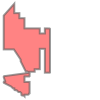

In [81]:
centroid_defo.iloc[210].geometry

In [78]:
centroid_defo.iloc[210]

C:\Users\covad\anaconda3\lib\site-packages\pandas\core\dtypes\inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
C:\Users\covad\anaconda3\lib\site-packages\pandas\core\dtypes\inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
C:\Users\covad\anaconda3\lib\site-packages\pandas\io\formats\printing.py:118: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = iter(seq)
C:\Users\covad\anaconda3\lib\site-packages\pandas\io\fo

uid                                                     1092459
state                                                        PA
path_row                                                  22763
main_class                                         DESMATAMENTO
class_name                                                d2019
def_cloud                                                   0.0
julian_day                                                221.0
image_date                                           2019-08-09
year                                                     2019.0
area_km                                                 0.29869
scene_id                                                   66.0
source                                                     None
satellite                                                  None
sensor                                                     None
uuid                       21ae4fe3-6a23-4d8f-a76f-23ed8ffd9e41
geometry      (POLYGON ((-54.33604401241

In [79]:
centroid_defo.iloc[209]

uid                                                      486969
state                                                        PA
path_row                                                  22763
main_class                                         DESMATAMENTO
class_name                                                d2016
def_cloud                                                   0.0
julian_day                                                258.0
image_date                                           2015-09-15
year                                                     2016.0
area_km                                                0.079318
scene_id                                               100062.0
source                                                     None
satellite                                                  None
sensor                                                     None
uuid                       ac3d4ac0-cc6e-4fe5-b388-30ad5891c1d3
geometry      POLYGON ((-54.315611831999

In [83]:
grid_gdf.within(centroid_defo.iloc[210].geometry)

TopologyException: side location conflict at -54.334260091560068 -3.6732286441133963. This can occur if the input geometry is invalid.


TopologicalError: The operation 'GEOSWithin_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.multipolygon.MultiPolygon object at 0x0000022E780CC970>

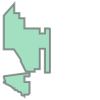

In [88]:
centroid_defo.iloc[210].geometry.buffer(0)

In [89]:
np.minimum(pd.concat(
        [grid_gdf.within(centroid_defo.iloc[x].geometry.buffer(0)) for x in range(0,len(centroid_defo))]
        , axis=1).sum(1),1)

0       0
1       0
2       0
3       0
4       0
       ..
1151    0
1152    0
1153    0
1154    0
1155    0
Length: 1156, dtype: int64